# Ensemble Strategy: Stacking & Blending

## 1. Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import sys
import os

# Add src to path
sys.path.append(os.path.abspath('..'))

from src.models import XGBoostModel, LightGBMModel, CatBoostModel, NeuralNetworkModel, StackingEnsemble, BlendingEnsemble
from src.utils.metrics import calculate_metrics

# Set plots style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load Processed Data

In [2]:
train_df = pd.read_csv('../data/processed/train_featurized.csv')
test_df = pd.read_csv('../data/processed/test_featurized.csv')

X = train_df.drop(['id', 'SMILES', 'Tm'], axis=1)
y = train_df['Tm']
X_test = test_df.drop(['id', 'SMILES'], axis=1)

# Handling NaNs for Neural Net consistency (Trees handle them, but standardizing helps ensemble)
X = X.fillna(X.mean())
X_test = X_test.fillna(X.mean())

## 3. Define Base Models
Using the best parameters found (simulated/default for now).

In [3]:
base_models = {
    'XGBoost': XGBoostModel({'n_estimators': 2000, 'learning_rate': 0.01}),
    'LightGBM': LightGBMModel({'n_estimators': 2000, 'learning_rate': 0.01}),
    'CatBoost': CatBoostModel({'iterations': 2000, 'learning_rate': 0.01}),
    'NeuralNet': NeuralNetworkModel({'epochs': 100, 'batch_size': 32})
}

## 4. Stacking Ensemble
Training a Ridge Regression meta-model on OOF predictions from base models.

In [4]:
print("Initializing Stacking Ensemble...")
stacking_model = StackingEnsemble(
    base_models=base_models,
    meta_model=Ridge(alpha=0.5),
    n_folds=5
)

print("Training Stacking Ensemble (this may take a while)...")
stacking_model.fit(X, y)

print("Predicting on Test Set...")
stack_preds = stacking_model.predict(X_test)

# Save Stacking Submission
sub_stack = pd.DataFrame({'id': test_df['id'], 'Tm': stack_preds})
sub_stack.to_csv('../submissions/submission_stacking.csv', index=False)
print("Saved Stacking submission.")

Initializing Stacking Ensemble...
Training Stacking Ensemble (this may take a while)...
Generating OOF predictions with 5 folds...
  Processing XGBoost...
  Processing LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19507
[LightGBM] [Info] Number of data points in the train set: 2129, number of used features: 635
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 278.149994
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l1: 29.0705
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013207 se

## 5. Blending Ensemble
Weighted average based on hypothetical performance (or manual weights).

In [5]:
# Assigning slightly higher weights to Tree models as they often outperform NN on tabular data
weights = {
    'XGBoost': 0.3,
    'LightGBM': 0.3,
    'CatBoost': 0.3,
    'NeuralNet': 0.1
}

print("Initializing Blending Ensemble...")
blending_model = BlendingEnsemble(
    models=base_models,
    weights=weights
)
# Note: base_models are already fitted by Stacking fit() call on full data at the end,
# but BlendingEnsemble.fit will call fit() again. That's okay.

print("Training Blending Ensemble (Refitting)... ")
blending_model.fit(X, y)

print("Predicting on Test Set...")
blend_preds = blending_model.predict(X_test)

# Save Blending Submission
sub_blend = pd.DataFrame({'id': test_df['id'], 'Tm': blend_preds})
sub_blend.to_csv('../submissions/submission_blending_weighted.csv', index=False)
print("Saved Blending submission.")

Initializing Blending Ensemble...
Training Blending Ensemble (Refitting)... 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20255
[LightGBM] [Info] Number of data points in the train set: 2662, number of used features: 707
[LightGBM] [Info] Start training from score 277.299988
Predicting on Test Set...
Saved Blending submission.


## 6. Final Comparison

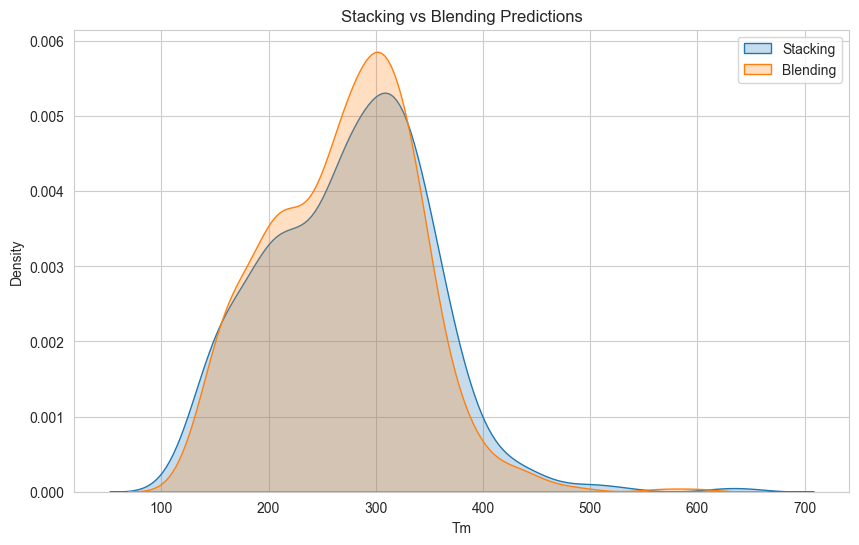

Correlation between Stacking and Blending: 0.9953


In [6]:
plt.figure(figsize=(10, 6))
sns.kdeplot(sub_stack['Tm'], label='Stacking', fill=True)
sns.kdeplot(sub_blend['Tm'], label='Blending', fill=True)
plt.title('Stacking vs Blending Predictions')
plt.legend()
plt.show()

corr = np.corrcoef(sub_stack['Tm'], sub_blend['Tm'])[0, 1]
print(f"Correlation between Stacking and Blending: {corr:.4f}")